<a href="https://colab.research.google.com/github/aimetz/Resume/blob/main/Random_Reinforcement_Learning_on_supervised_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np


class Layer:
    def __init__(self, n_inputs, n_neurons):
        self.size = (n_inputs, n_neurons)
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.bias = np.zeros((1, n_neurons))

    def __repr__(self):
        return "Weights:\n{}\nBias:\n{}\n".format(self.weights, self.bias) 
    
    
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.bias
        return self.output
    
    def lin_rect_act(self):
        self.output_act = np.maximum(0, self.output)
        return self.output_act

    def sigmoid_act(self):
        self.output_act = 1/(1+np.power(np.e, self.output))
        return self.output_act
    
    def mutate(self, intensity):
        new = Layer(self.size[0], self.size[1])
        new.weights = self.weights+.001*intensity*np.random.randn(self.size[0], self.size[1])
        new.bias = self.bias+.001*intensity*np.random.randn(1, self.size[1])
        return new


class NN:
    def __init__(self, num_layers, sizes):
        self.nl = num_layers
        self.sizes = sizes
        if num_layers != len(sizes)-1:
            raise ValueError
        self.layers = [None]*num_layers
        for i in range(num_layers):
            self.layers[i] = Layer(sizes[i], sizes[i+1])

    def __repr__(self):
        return "Sizes:\n{}\nLayers:\n{}".format(self.sizes, self.layers)

            
    def f_pass(self, inputs, how="lin_rect"):
        if type(inputs) == pd.DataFrame:
            self.output = inputs.values#np.array([inputs.values.tolist()]).T.tolist()
        else:
            self.output = inputs
        for i in range(self.nl):
            self.output = self.layers[i].forward(self.output)
            if i < self.nl-1 and how == "sigmoid":
                self.output = self.layers[i].sigmoid_act()
            elif i < self.nl-1 and how == "lin_rect":
                self.output = self.layers[i].lin_rect_act()
        return self.output

    def mutate(self, intensity):
       new = NN(self.nl, self.sizes)
       for i, layer in enumerate(self.layers):
           new.layers[i] = layer.mutate(intensity)
       return new


In [ ]:
class Generation:
    def __init__(self, population, sizes=None, initial=False):
        if initial:
            NNs = [None] * population
            for i in range(population):
                NNs[i] = NN(len(sizes)-1, sizes)
            self.pop = NNs
            self.sizes = sizes
        else:
            self.pop = population


    def f_pass(self, data, label=None, how="lin_rect"):
        size = len(self.pop)
        y_ = [None] * size
        errors = [None] * size
        for i in range(size):
            y_[i] = self.pop[i].f_pass(data, how=how)
            if label is not None:
                errors[i] = np.sqrt((label - y_[i].T[0])**2).mean()
        if label is not None:
            self.errors = pd.Series(errors).sort_values()
        return y_

    def f_pass_sep_inputs(self, data, label=None, how="lin_rect"):
        size = len(self.pop)
        y_ = [None] * size
        errors = [None] * size
        for i in range(size):
            y_[i] = self.pop[i].f_pass(data[i], how=how)
        return y_

    def next_gen(self):
        survivors = 5
        best = self.errors.index.tolist()[:survivors]
        next_gen = [None]*survivors*201
        for i, index in enumerate(best):
            next_gen[i] = self.pop[index]
            for ten in range(100):
                if i<2:
                    for q in range(2):
                        next_gen[i*200+ten*2+q+5] = self.pop[index].mutate(ten)
                else:
                    next_gen[i*200+ten*2+5] = self.pop[index].mutate(ten)
                    next_gen[i*200+ten*2+6] = NN(len(self.sizes)-1, self.sizes)
        g = Generation(next_gen)
        g.sizes = self.sizes
        return g

In [ ]:
# def rand_train(shape, x, starting=1000, gens=10): 
#     gen = Generation(starting, shape, True)
#     errs = pd.Series(dtype=float)
#     for i in range(gens):
#         print(str(100*i//gens)+"% Done")
#         gen.f_pass(x, y)
#         errs.loc[i] = gen.errors.iloc[0]
#         gen = gen.next_gen()
#         clear_output()
#     gen.f_pass(x, y)
#     ind = gen.errors.index[0]
#     return pd.Series(gen.pop[ind].f_pass(x).T[0]), errs 

In [ ]:
from IPython.display import clear_output
def rand_train(shape, x, y, starting=1000, gens=10, how="lin_rect"): 
    gen = Generation(starting, shape, True)
    errs = pd.Series(dtype=float)
    for i in range(gens):
        print(str(100*i//gens)+"% Done")
        gen.f_pass(x, y, how=how)
        errs.loc[i] = gen.errors.iloc[0]
        gen = gen.next_gen()
        clear_output()
    gen.f_pass(x, y)
    ind = gen.errors.index[0]
    return pd.Series(gen.pop[ind].f_pass(x).T[0]), errs, gen.pop[ind]


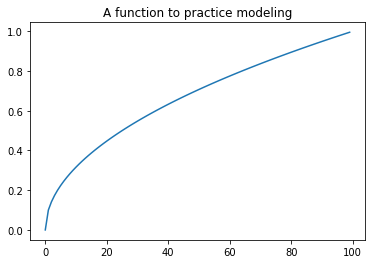

In [3]:
import pandas as pd

x = np.array(range(100))
y = np.sqrt(x)/10
Data = pd.Series(y, index=x)
Data.plot.line(title ="A function to practice modeling")

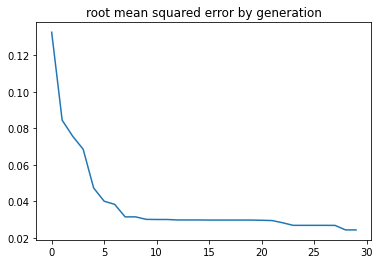

In [ ]:
reg = rand_train([1, 10, 10, 10, 1], np.array([Data.index]).T, Data.values, gens=30, how="lin_rect")
reg[1].plot.line(title = "root mean squared error by generation")

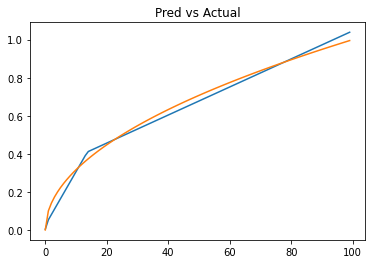

In [ ]:
reg[0].plot.line()
Data.plot.line(title = "Pred vs Actual")

In [ ]:
tips = pd.read_csv("https://dlsun.github.io/pods/data/"+"tips.csv")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


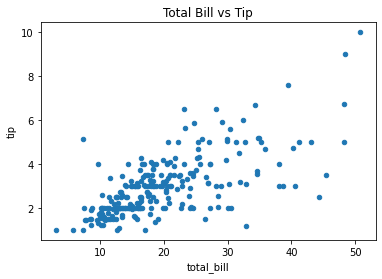

In [ ]:
tips.plot.scatter(x="total_bill", y='tip', title = "Total Bill vs Tip")

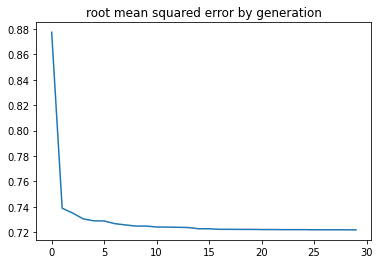

In [ ]:
reg = rand_train([1, 10, 10, 10, 1], tips[["total_bill"]], tips["tip"], gens=30, how="lin_rect")
reg[1].plot.line(title = "root mean squared error by generation")

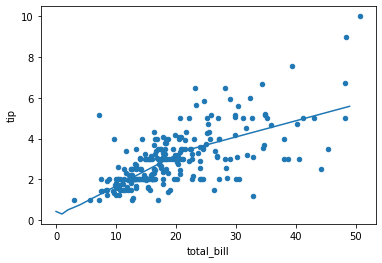

In [ ]:
pred = pd.Series(reg[2].f_pass(pd.DataFrame(range(50))).T[0])
tips.plot.scatter(x="total_bill", y='tip')
pred.plot.line()

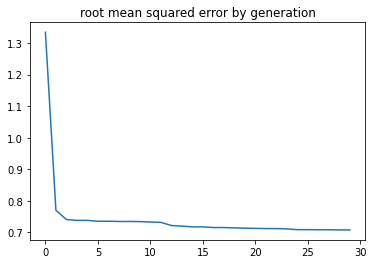

In [ ]:
reg = rand_train([2, 10, 20, 10, 1], tips[["total_bill", "size"]], tips["tip"], gens=30, how="lin_rect")
reg[1].plot.line(title = "root mean squared error by generation")

In [ ]:
new = tips[["total_bill", "size"]].merge(pd.get_dummies(tips["sex"]), left_index=True, right_index=True)
new

,total_bill,size,Female,Male
0,16.99,2,1,0
1,10.34,3,0,1
2,21.01,3,0,1
3,23.68,2,0,1
4,24.59,4,1,0
...,...,...,...,...
239,29.03,3,0,1
240,27.18,2,1,0
241,22.67,2,0,1
242,17.82,2,0,1


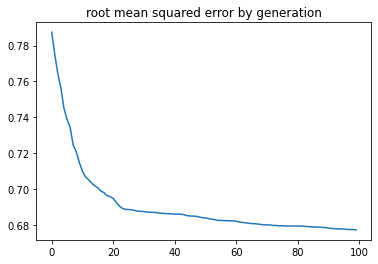

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_st = scaler.fit_transform(new)
a = rand_train(x=pd.DataFrame(X_train_st), y=tips["tip"], shape=[4, 30, 20, 10, 1], gens=100, how="sigmoid")
a[1].plot.line(title = "root mean squared error by generation")

In [ ]:
print("Root Mean Squared Error on Training data for my method: " + str(a[1][99])+
"\nmy predictions were on average 67.7 cents away from the correct tip")

Root Mean Squared Error on Training data for my method: 0.6771494368216777
my predictions were on average 67.7 cents away from the correct tip


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Standardize the training and test data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(new)
y_train = tips["tip"]

# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=8)
model.fit(X=X_train_st, y=y_train)
"Root Mean Squared Error on Training data for KnearestNeighbors: " + str(np.sqrt((model.predict(X=X_train_st)-tips["tip"])**2).mean())

'Root Mean Squared Error on Training data for KnearestNeighbors: 0.7015727459016398'

In [ ]:
from sklearn.linear_model import LinearRegression

# Standardize the training and test data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(new)
y_train = tips["tip"]

# Fit k-nearest neighbors
model = LinearRegression()
model.fit(X=X_train_st, y=y_train)
"Root Mean Squared Error on Training data for LinearRegression: " + str(np.sqrt((model.predict(X=X_train_st)-tips["tip"])**2).mean())

'Root Mean Squared Error on Training data for LinearRegression: 0.7387153912128794'